In [1]:
# Import the functions used in this project
# from private_pkg.functions import *

# Pretty display for notebooks
%matplotlib inline

# Ignore the warnings
import warnings
warnings.filterwarnings('ignore')

# Load the dataset
train = pd.read_csv("../asset/train.csv")
test = pd.read_csv("../asset/test.csv")
submission = pd.read_csv("../asset/sample_submission.csv")

# Success - Display the first record
print("Train data : ", train.shape)
print("Test  data : ", test.shape)
print("submission  data : ", submission.shape)

# 원본을 유지하기 위해서 카피
df_train = train.copy()
df_test = test.copy()
df_submission = submission.copy()

Train data :  (647054, 7)
Test  data :  (653646, 6)
submission  data :  (95674, 39)


In [131]:
%%writefile private_pkg/functions.py

import numpy as np
from IPython.display import display, Markdown

def getNullDataInfo(df):
    """
        패러미터 종류 : df
        df : 컬럼별로 np.nan데이터의 총 개수를 DataFrame형식으로 반환한다.
    """
    df = df.isnull().sum().reset_index()
    df.columns = ["Feature_name", "Sum of null data"]
    return df

def getNullDataDetailInfo(df, specify_col = [], see_list_detail = False, visit_number_threshold = 2):
    """
        패러미터 종류 : df, specify_col, see_list_detail
        df : 확인하고자하는 데이터프레임을 넣어준다.
        specify_col : 보고싶은 컬럼들의 이름을 리스트형식으로 넣어준다. default는 []이며, 이 경우에는 모든 컬럼에대한 정보를 다 보여준다. 
        see_list_detail : 분포를 리스트형식 파일로도 보고싶은 경우에 True를 넣어준다. default는 False
        visit_number_threshold : 0보다 큰 정수를 넣어줘야한다. default는 2
    """
    df_ = df[df["Upc"].isnull()]
    if specify_col == []:
        cols = list(df_.columns)
    else:
        cols = specify_col
    for col in cols:
        unique = df_[col].unique()
        print()
        print(str(col) + " 컬럼의 유니크 데이터 정보(" + str(len(unique)) + "종류)")
        if see_list_detail:
            print(unique)
        print()
        print("데이터별 분포")
        __getNullDataDistributionByColumn(df_, col, see_list_detail, visit_number_threshold, df)        
        print()
        if len(cols) > 1:
            print("================================================================================")
            
def __getNullDataDistributionByColumn(df, col, see_list_detail, visit_number_threshold, original_df):
    try:
        unique_li = sorted(df[col].unique())
    except:
        unique_li = df[col].unique()
    data_name_li = []
    len_li = []
    if col == "VisitNumber":
        data_name_li, len_li = __getMoreAnalyzedVisitNumber(df, unique_li, col, visit_number_threshold, original_df)
    else:
        for unique in list(unique_li):
            data_name_li.append(unique)
            if type(unique) is not str:
                unique = float(unique)
            if type(unique) is float:
                if np.isnan(unique):
                    len_li.append(len(df[df[col].isnull()]))
                else:
                    len_li.append(len(df[df[col] == unique]))                
            else:        
                len_li.append(len(df[df[col] == unique]))
    if see_list_detail:
        print(dict(zip(data_name_li, len_li)))
    else:
        if len(unique_li) == 1:
            print(dict(zip(data_name_li, len_li)))
    if len(unique_li) > 1 and col != "VisitNumber":
        data_name_li = [ 'Null' if type(d) is float and np.isnan(d) else d for d in data_name_li]
        plt.figure(figsize=(10, 5))
        sns.barplot(x = data_name_li, y = len_li)
        plt.xticks(rotation = 90)
        plt.show()

def __getMoreAnalyzedVisitNumber(df, unique_li, col, visit_number_threshold, original_df):
    df_null_mask = []
    df_pharmacy_mask = []
    data_name_li = []
    len_li = []
    for unique in list(unique_li):
        length = len(df[df[col] == unique])
        if length >= visit_number_threshold:            
            data_name_li.append(unique)
            len_li.append(length)
    
    display(Markdown("## 여기서 세가지 모두 Null인 아이템이란 Upc, DepartmentDescription, FinelineNumber가 다 NaN인 경우를 말한다.\
    또한 두가지가 Null인 아이템이란 Upc, FinelineNumber가 NaN이면서 DepartmentDescription은 PHARMACY RX인 경우를 말한다."))
    
    df_dd_null = df[df["DepartmentDescription"].isnull()]
    df_null_mask = df_dd_null["VisitNumber"].isin(data_name_li)
    df_dd_null_visit_number_above_threshold = df_dd_null[df_null_mask]
    ppl_nbr = len(df_dd_null_visit_number_above_threshold["VisitNumber"].unique())
    print("세가지 컬럼이 모두 Null인 " + str(visit_number_threshold) + "가지 이상 종류의 아이템을 산 사람은 총 " + str(ppl_nbr) + "명이다.")
    __drawTripTypeBarPlot(df_dd_null_visit_number_above_threshold, original_df, df, False, visit_number_threshold)
    
    df_dd_pharmacy = df[df["DepartmentDescription"] == "PHARMACY RX"]
    df_pharmacy_mask = df_dd_pharmacy["VisitNumber"].isin(data_name_li)
    df_dd_pharmacy_visit_number_above_threshold = df_dd_pharmacy[df_pharmacy_mask]
    ppl_nbr = len(df_dd_pharmacy_visit_number_above_threshold["VisitNumber"].unique())
    print("두가지 컬럼이 모두 Null인 " + str(visit_number_threshold) + "가지 이상 종류의 아이템을 산 사람은 총 " + str(ppl_nbr) + "명이다.")
    __drawTripTypeBarPlot(df_dd_pharmacy_visit_number_above_threshold, original_df, df, True, visit_number_threshold)
    
    print("위 두가지 경우의 합이 VisitNumber컬럼의 유니크한 데이터 총 개수와 다른 이유는 23757, 50745")
    print("VisitNumber에 해당하는 두 명이 세가지 다 Null인 아이템과 Pharmacy RX 제품 두개다 구매했기 때문이다.")
    display(df[df["VisitNumber"] == 23757])
    display(df[df["VisitNumber"] == 50745])
    
    __getDetailInfoAboutVisitNumberBoughtNotNullProduct(data_name_li, original_df, visit_number_threshold)
    
    return data_name_li, len_li

def __drawTripTypeBarPlot(df, original_df, original_df_with_only_null, isNull, visit_number_threshold):
    col = "TripType"
    unique_li = sorted(original_df[col].unique())
    data_name_li = []
    len_li = []
    for unique in list(unique_li):
        length = len(df[df[col] == unique])         
        data_name_li.append(unique)
        len_li.append(length)
    plt.figure(figsize=(10, 5))
    sns.barplot(x = data_name_li, y = len_li)
    plt.xticks(rotation = 90)
    plt.show()
    if isNull:
        percentage = str(round(np.array(len_li).max()/sum(len_li), 2) * 100) + "%"
        display(Markdown('## **Pharmacy rx인 경우에는 {}가 TripType 5에 해당한다.**'.format(percentage)))
        display(Markdown('## **두가지 컬럼이 Null인 {}가지 이상 종류의 아이템을 산사람들의 분포이다.**'.format(visit_number_threshold)))        
    else:
        percentage = str(round(np.array(len_li).max()/sum(len_li), 2) * 100) + "%"
        display(Markdown('## **Upc, DepartmentDescription, FinelineNumber 모두 Null인 경우에는 999 type이 {}를 차지한다.**'.format(percentage)))        
        display(Markdown('## **세가지 컬럼이 모두 Null인 {}가지 이상 종류의 아이템을 산사람들의 분포이다.**'.format(visit_number_threshold)))        
        
def __getDetailInfoAboutVisitNumberBoughtNotNullProduct(data_name_li, original_df_, visit_number_threshold):
    col = "VisitNumber"
    original_df = original_df_.copy()
    cut_off_df = original_df_[original_df_["Upc"].isnull()]
    df_null_mask = original_df["VisitNumber"].isin(data_name_li)
    null_df = original_df[df_null_mask]
    null_li = null_df[col].unique()
    uq_li = []
    uq_li_who_bought_only_null_products = []
    for li in null_li:
        if len(null_df[null_df[col] == li]["Upc"].unique()) > 1:
            uq_li.append(li)
        else:
            uq_li_who_bought_only_null_products.append(li)
            
    null_df = original_df_[original_df_[col].isin(uq_li)]    
    cut_off_null_df = cut_off_df[cut_off_df[col].isin(uq_li)]

    display(Markdown("#### Null이 포함된 " + str(visit_number_threshold) + "가지 이상의 아이템을 산 사람들의 null 아이템 정보(df.tail)"))
    display(cut_off_null_df.tail())     
    display(Markdown("#### Null이 포함된 " + str(visit_number_threshold) + "가지 이상의 아이템을 산 사람들의 모든 아이템 정보(df.tail)"))
    display(null_df.tail())     
#     display(null_df.groupby("VisitNumber"))
    
    display(Markdown("## 총 " + __setColoredText(len(null_li)) + "명의 사람들 중에 " + __setColoredText(len(uq_li)) + "(" + __setColoredText(round(len(uq_li)/len(null_li), 2) * 100) + "%)명에 해당하는 사람들은 Null 데이터가 아닌 아이템도 샀다."))
    display(Markdown("## 즉, " + __setColoredText(len(null_li) - len(uq_li)) + "명의 사람만이 Null 데이터만 가진 아이템을 샀다."))
    
#     display(len(uq_li_who_bought_only_null_products), uq_li_who_bought_only_null_products[:5])
    df_only_bought_null_products = cut_off_df[cut_off_df["VisitNumber"].isin(uq_li_who_bought_only_null_products)]
    
    df_only_bought_null_pharmacy_products = df_only_bought_null_products[df_only_bought_null_products["DepartmentDescription"] == "PHARMACY RX"]
    df_only_bought_null_not_pharmacy_products = df_only_bought_null_products[df_only_bought_null_products["DepartmentDescription"] != "PHARMACY RX"]
    
    display(df_only_bought_null_pharmacy_products.tail())
    unique_nbr = len(df_only_bought_null_pharmacy_products["VisitNumber"].unique())
    display(Markdown("## 그 " +  str(len(null_li) - len(uq_li)) + "명 중에 " + str(unique_nbr) + " 명이 Pharmacy 제품만을 산사람이다."))
    
    display(df_only_bought_null_not_pharmacy_products.tail())
    uq_li_999 = df_only_bought_null_not_pharmacy_products["VisitNumber"].unique()
    unique_nbr_ = len(uq_li_999)
    display(Markdown("## 그 " +  str(len(null_li) - len(uq_li)) + "명 중에 " + str(unique_nbr_) + " 명이 Null 제품만을 산사람이다."))
#     display(df_only_bought_null_not_pharmacy_products["TripType"].unique())
    display(Markdown("## 이 사람들의 TripType은 모두 "+ __setColoredText(999) + "이다."))
    
    special_vn_li = []
    for nbr in uq_li_999:
        sumOfScanCount = df_only_bought_null_not_pharmacy_products[df_only_bought_null_not_pharmacy_products["VisitNumber"] == nbr]["ScanCount"].sum()
        if sumOfScanCount > 0:
            special_vn_li.append(nbr)
    display(Markdown("## 그 중에서 VisitNumber별로 ScanCount의 Sum이 0이상인 경우(실제로 NaN아이템을 산사람)의 VisitNumber list다."))            
    print(special_vn_li)
    
def __setColoredText(txt, color_rgb = "red"):
    return "<span style='color:" + color_rgb +"'>" + str(txt) + "</span>"

Overwriting private_pkg/functions.py



VisitNumber 컬럼의 유니크 데이터 정보(2754종류)

데이터별 분포


## 여기서 세가지 모두 Null인 아이템이란 Upc, DepartmentDescription, FinelineNumber가 다 NaN인 경우를 말한다.    또한 두가지가 Null인 아이템이란 Upc, FinelineNumber가 NaN이면서 DepartmentDescription은 PHARMACY RX인 경우를 말한다.

세가지 컬럼이 모두 Null인 1가지 이상 종류의 아이템을 산 사람은 총 1172명이다.


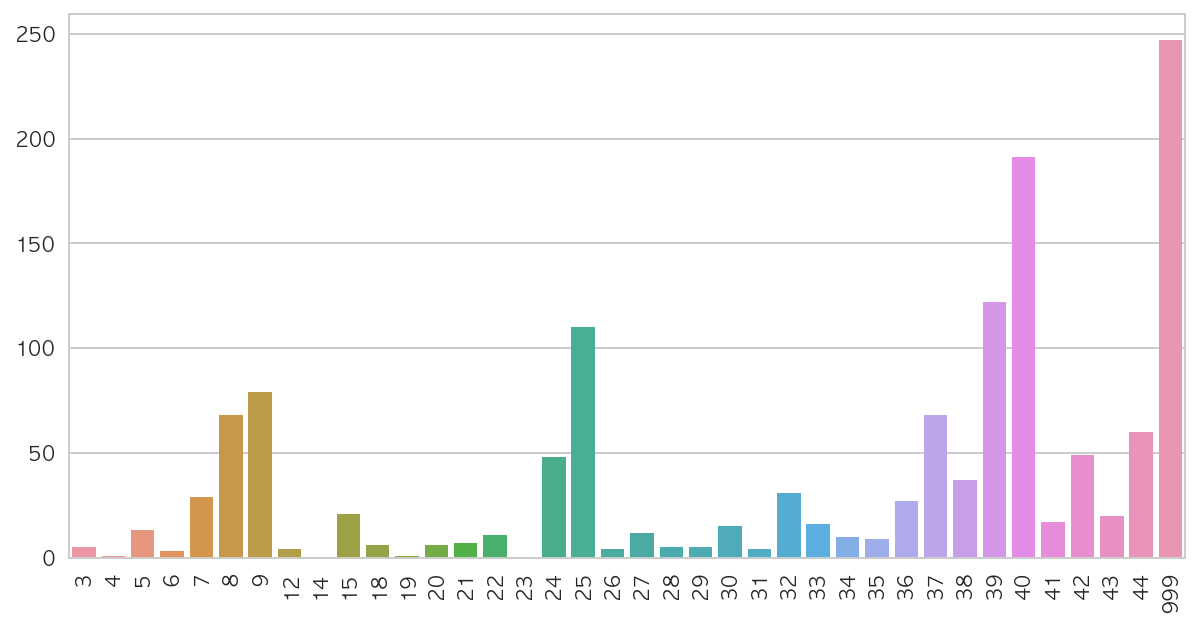

## **Upc, DepartmentDescription, FinelineNumber 모두 Null인 경우에는 999 type이 18.0%를 차지한다.**

## **세가지 컬럼이 모두 Null인 1가지 이상 종류의 아이템을 산사람들의 분포이다.**

두가지 컬럼이 모두 Null인 1가지 이상 종류의 아이템을 산 사람은 총 1584명이다.


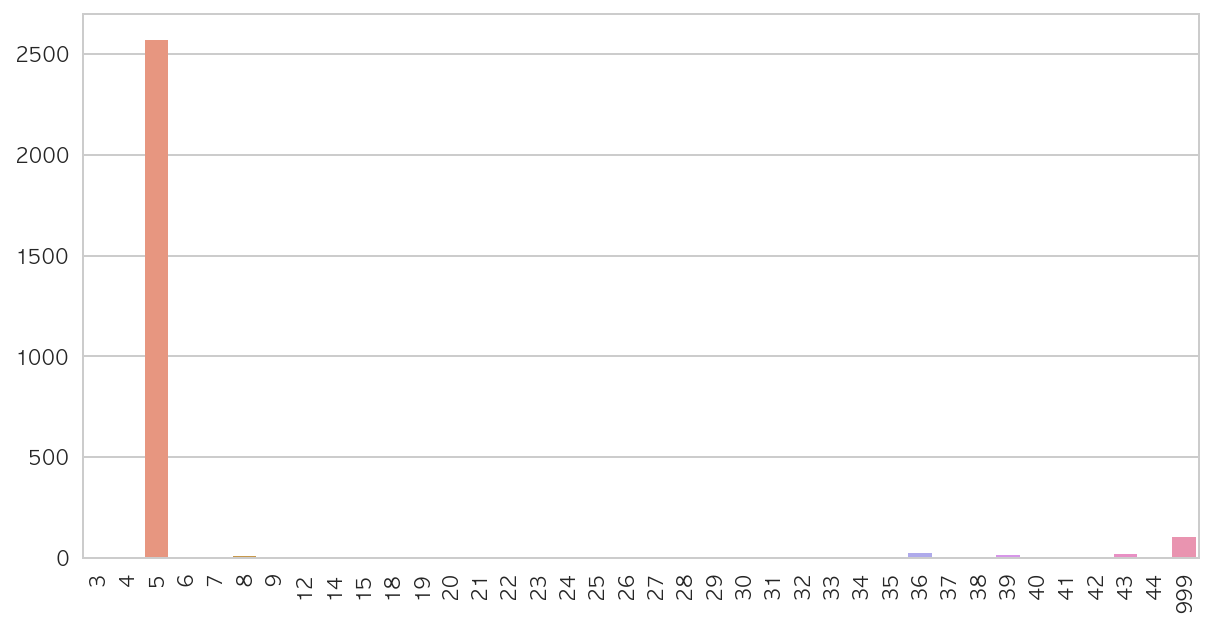

## **Pharmacy rx인 경우에는 93.0%가 TripType 5에 해당한다.**

## **두가지 컬럼이 Null인 1가지 이상 종류의 아이템을 산사람들의 분포이다.**

위 두가지 경우의 합이 VisitNumber컬럼의 유니크한 데이터 총 개수와 다른 이유는 23757, 50745
VisitNumber에 해당하는 두 명이 세가지 다 Null인 아이템과 Pharmacy RX 제품 두개다 구매했기 때문이다.


,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
83041,5,23757,Monday,NaN,1,PHARMACY RX,NaN
83042,5,23757,Monday,NaN,1,NaN,NaN


,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
167470,36,50745,Saturday,NaN,1,PHARMACY RX,NaN
167471,36,50745,Saturday,NaN,1,PHARMACY RX,NaN
167472,36,50745,Saturday,NaN,1,NaN,NaN


#### Null이 포함된 1가지 이상의 아이템을 산 사람들의 null 아이템 정보(df.tail)

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
643137,41,190408,Sunday,NaN,1,NaN,NaN
643991,44,190651,Sunday,NaN,1,NaN,NaN
645990,44,191080,Sunday,NaN,-1,NaN,NaN
645991,44,191080,Sunday,NaN,1,NaN,NaN
645992,44,191080,Sunday,NaN,1,NaN,NaN


#### Null이 포함된 1가지 이상의 아이템을 산 사람들의 모든 아이템 정보(df.tail)

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
645988,44,191080,Sunday,4.480071e+09,1,GROCERY DRY GOODS,4454.0
645989,44,191080,Sunday,2.471931e+09,1,HORTICULTURE AND ACCESS,8010.0
645990,44,191080,Sunday,NaN,-1,NaN,NaN
645991,44,191080,Sunday,NaN,1,NaN,NaN
645992,44,191080,Sunday,NaN,1,NaN,NaN


## 총 <span style='color:red'>2754</span>명의 사람들 중에 <span style='color:red'>1327</span>(<span style='color:red'>48.0</span>%)에 해당하는 사람들은 Null 데이터가 아닌 아이템도 샀다.

## 즉, <span style='color:red'>1427</span>명의 사람만이 Null 데이터만 가진 아이템을 샀다.

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
636715,5,188839,Sunday,NaN,1,PHARMACY RX,NaN
636716,5,188839,Sunday,NaN,1,PHARMACY RX,NaN
636717,5,188839,Sunday,NaN,1,PHARMACY RX,NaN
636847,5,188896,Sunday,NaN,1,PHARMACY RX,NaN
637198,5,188940,Sunday,NaN,1,PHARMACY RX,NaN


## 그 1427명 중에 1269 명이 Pharmacy 제품만을 산사람이다.

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
627629,999,186659,Sunday,NaN,-1,NaN,NaN
627630,999,186659,Sunday,NaN,-1,NaN,NaN
631875,999,187677,Sunday,NaN,-1,NaN,NaN
634700,999,188355,Sunday,NaN,-1,NaN,NaN
636444,999,188760,Sunday,NaN,-1,NaN,NaN


## 그 1427명 중에 158 명이 Null 제품만을 산사람이다.

## 이 사람들의 TripType은 모두 <span style='color:red'>999</span>이다.

## 그 중에서 VisitNumber별로 ScanCount의 Sum이 0이상인 경우(실제로 NaN아이템을 산사람)의 VisitNumber list다.

[3004, 3149, 4884, 11325, 13094, 14684, 16747, 18103, 19362, 20131, 22927, 23848, 23926, 27920, 30249, 38585, 44514, 46436, 47459, 51002, 56392, 56659, 57477, 59636, 60958, 61766, 62071, 62742, 68328, 70594, 72118, 78069, 78338, 83396, 87819, 89032, 89225, 89589, 90354, 91660, 92482, 99178, 99970, 102743, 112129, 119765, 121736, 121931, 122186, 122981, 125287, 126624, 127851, 128041, 128205, 131018, 131414, 132830, 144843, 145731, 145860, 147592, 147840, 155706, 159342, 161878, 162326, 164978, 165909, 166029, 171254, 171625, 179175, 181334, 184578]



In [103]:
getNullDataDetailInfo(df_train, ["VisitNumber"], visit_number_threshold = 1)

In [28]:
len(df_train)

647054

In [42]:
len(df_train[df_train["ScanCount"] < 0])

15458

In [64]:
special_li = [3004, 3149, 4884, 11325, 13094, 14684, 16747, 18103, 19362, 20131, 22927, 23848, 23926, 27920, 30249, 38585, 44514, 46436, 47459, 51002, 56392, 56659, 57477, 59636, 60958, 61766, 62071, 62742, 68328, 70594, 72118, 78069, 78338, 83396, 87819, 89032, 89225, 89589, 90354, 91660, 92482, 99178, 99970, 102743, 112129, 119765, 121736, 121931, 122186, 122981, 125287, 126624, 127851, 128041, 128205, 131018, 131414, 132830, 144843, 145731, 145860, 147592, 147840, 155706, 159342, 161878, 162326, 164978, 165909, 166029, 171254, 171625, 179175, 181334, 184578]

In [65]:
for li in special_li:
    display(df_train[df_train["VisitNumber"] == li])

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
8524,999,3004,Friday,NaN,1,NaN,NaN


,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
9094,999,3149,Friday,NaN,1,NaN,NaN


,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
14917,999,4884,Friday,NaN,1,NaN,NaN


,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
38076,999,11325,Saturday,NaN,1,NaN,NaN


,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
44211,999,13094,Sunday,NaN,1,NaN,NaN


,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
50413,999,14684,Sunday,NaN,1,NaN,NaN


,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
58696,999,16747,Sunday,NaN,1,NaN,NaN


,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
64604,999,18103,Sunday,NaN,1,NaN,NaN


,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
69154,999,19362,Sunday,NaN,1,NaN,NaN


,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
71482,999,20131,Monday,NaN,1,NaN,NaN


,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
80446,999,22927,Monday,NaN,1,NaN,NaN


,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
83307,999,23848,Monday,NaN,1,NaN,NaN


,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
83704,999,23926,Monday,NaN,2,NaN,NaN


,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
96863,999,27920,Tuesday,NaN,1,NaN,NaN


,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
104113,999,30249,Tuesday,NaN,1,NaN,NaN


,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
129047,999,38585,Thursday,NaN,1,NaN,NaN


,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
146995,999,44514,Friday,NaN,1,NaN,NaN


,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
152550,999,46436,Friday,NaN,1,NaN,NaN


,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
155807,999,47459,Friday,NaN,1,NaN,NaN


,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
168383,999,51002,Saturday,NaN,1,NaN,NaN


,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
189238,999,56392,Sunday,NaN,1,NaN,NaN
189239,999,56392,Sunday,NaN,1,NaN,NaN


,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
190277,999,56659,Sunday,NaN,1,NaN,NaN


,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
193105,999,57477,Sunday,NaN,1,NaN,NaN


,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
200928,999,59636,Sunday,NaN,1,NaN,NaN
200929,999,59636,Sunday,NaN,1,NaN,NaN


,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
205931,999,60958,Sunday,NaN,1,NaN,NaN


,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
209309,999,61766,Sunday,NaN,1,NaN,NaN
209310,999,61766,Sunday,NaN,1,NaN,NaN


,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
210257,999,62071,Sunday,NaN,1,NaN,NaN


,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
213102,999,62742,Sunday,NaN,1,NaN,NaN
213103,999,62742,Sunday,NaN,1,NaN,NaN


,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
231541,999,68328,Monday,NaN,1,NaN,NaN


,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
238728,999,70594,Tuesday,NaN,1,NaN,NaN


,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
243558,999,72118,Tuesday,NaN,1,NaN,NaN


,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
262126,999,78069,Wednesday,NaN,2,NaN,NaN
262127,999,78069,Wednesday,NaN,1,NaN,NaN


,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
262900,999,78338,Wednesday,NaN,1,NaN,NaN


,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
278584,999,83396,Thursday,NaN,1,NaN,NaN


,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
291975,999,87819,Friday,NaN,1,NaN,NaN


,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
295622,999,89032,Friday,NaN,1,NaN,NaN
295623,999,89032,Friday,NaN,1,NaN,NaN


,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
296176,999,89225,Friday,NaN,1,NaN,NaN


,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
297117,999,89589,Friday,NaN,2,NaN,NaN


,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
299728,999,90354,Friday,NaN,1,NaN,NaN


,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
303857,999,91660,Friday,NaN,1,NaN,NaN


,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
306718,999,92482,Friday,NaN,1,NaN,NaN


,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
331801,999,99178,Saturday,NaN,1,NaN,NaN


,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
334790,999,99970,Sunday,NaN,1,NaN,NaN
334791,999,99970,Sunday,NaN,1,NaN,NaN


,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
345914,999,102743,Sunday,NaN,1,NaN,NaN


,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
380956,999,112129,Monday,NaN,1,NaN,NaN


,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
404857,999,119765,Wednesday,NaN,1,NaN,NaN


,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
410741,999,121736,Wednesday,NaN,1,NaN,NaN


,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
411334,999,121931,Wednesday,NaN,2,NaN,NaN
411335,999,121931,Wednesday,NaN,3,NaN,NaN
411336,999,121931,Wednesday,NaN,1,NaN,NaN


,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
412109,999,122186,Wednesday,NaN,1,NaN,NaN


,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
414497,999,122981,Wednesday,NaN,1,NaN,NaN


,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
421954,999,125287,Thursday,NaN,1,NaN,NaN


,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
425622,999,126624,Thursday,NaN,1,NaN,NaN


,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
429217,999,127851,Thursday,NaN,1,NaN,NaN


,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
430023,999,128041,Thursday,NaN,1,NaN,NaN


,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
430385,999,128205,Thursday,NaN,1,NaN,NaN


,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
439517,999,131018,Friday,NaN,1,NaN,NaN


,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
440643,999,131414,Friday,NaN,1,NaN,NaN


,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
444939,999,132830,Friday,NaN,1,NaN,NaN


,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
487605,999,144843,Sunday,NaN,1,NaN,NaN
487606,999,144843,Sunday,NaN,2,NaN,NaN


,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
490759,999,145731,Sunday,NaN,1,NaN,NaN


,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
491348,999,145860,Sunday,NaN,1,NaN,NaN


,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
497774,999,147592,Sunday,NaN,1,NaN,NaN


,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
498441,999,147840,Sunday,NaN,1,NaN,NaN


,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
526898,999,155706,Monday,NaN,1,NaN,NaN


,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
537793,999,159342,Tuesday,NaN,1,NaN,NaN


,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
545871,999,161878,Wednesday,NaN,1,NaN,NaN
545872,999,161878,Wednesday,NaN,3,NaN,NaN


,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
547004,999,162326,Wednesday,NaN,1,NaN,NaN


,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
555728,999,164978,Wednesday,NaN,1,NaN,NaN


,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
558868,999,165909,Wednesday,NaN,1,NaN,NaN


,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
559177,999,166029,Wednesday,NaN,1,NaN,NaN


,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
574660,999,171254,Thursday,NaN,1,NaN,NaN


,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
575910,999,171625,Thursday,NaN,1,NaN,NaN
575911,999,171625,Thursday,NaN,1,NaN,NaN


,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
600332,999,179175,Saturday,NaN,1,NaN,NaN


,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
608156,999,181334,Saturday,NaN,1,NaN,NaN


,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
619734,999,184578,Sunday,NaN,1,NaN,NaN


In [69]:
df_train_999 = df_train[df_train["TripType"] == 999]

In [70]:
vn_list = []
for uq in df_train_999["VisitNumber"].unique():
    df = df_train_999[df_train_999["VisitNumber"] == uq]
    sumOfScanCount = df["ScanCount"].sum()
    if sumOfScanCount > 0:
        vn_list.append(uq) 

In [74]:
len(vn_list)
vn_list[:5]

[207, 295, 351, 357, 436]

In [73]:
len(df_train_999["VisitNumber"].unique())

8444

In [75]:
df_train[df_train["VisitNumber"] == 207]

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
399,999,207,Friday,7.616352e+10,1,PRODUCE,3509.0
400,999,207,Friday,2.242229e+09,2,DSD GROCERY,7957.0


In [84]:
getNullDataInfo(df_train)

,Feature_name,Sum of null data
0,TripType,0
1,VisitNumber,0
2,Weekday,0
3,Upc,4129
4,ScanCount,0
5,DepartmentDescription,1361
6,FinelineNumber,4129


In [86]:
all_null_df = df_train[df_train["DepartmentDescription"].isnull()]

In [88]:
len(all_null_df["VisitNumber"].unique())

1172

In [118]:
df_we_wanted = pd.DataFrame(df_train.groupby(["VisitNumber", "TripType", "DepartmentDescription"]).sum()["ScanCount"]).reset_index()

In [119]:
df_we_wanted

,VisitNumber,TripType,DepartmentDescription,ScanCount
0,5,999,FINANCIAL SERVICES,-1
1,7,30,PERSONAL CARE,1
2,7,30,SHOES,1
3,8,26,DAIRY,2
4,8,26,DSD GROCERY,1
5,8,26,HOUSEHOLD CHEMICALS/SUPP,1
6,8,26,MEAT - FRESH & FROZEN,1
7,8,26,PAINT AND ACCESSORIES,18
8,8,26,PETS AND SUPPLIES,4
9,9,8,IMPULSE MERCHANDISE,1


In [123]:
columns = [uq for uq in df_train["DepartmentDescription"].unique() if not type(uq) is float]

In [125]:
li = np.zeros(len(columns))

In [126]:
list(li)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [130]:
dict_ = dict(zip(columns, li.astype(int)))

TypeError: 'dict' object is not callable